In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

### Etudier la répartition des textes par émotions

In [3]:
df = pd.read_csv('Emotion_final.csv')

In [4]:
emotion_counts = df['Emotion'].value_counts()
emotion_counts

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

Text(0, 0.5, 'Nombre de textes')

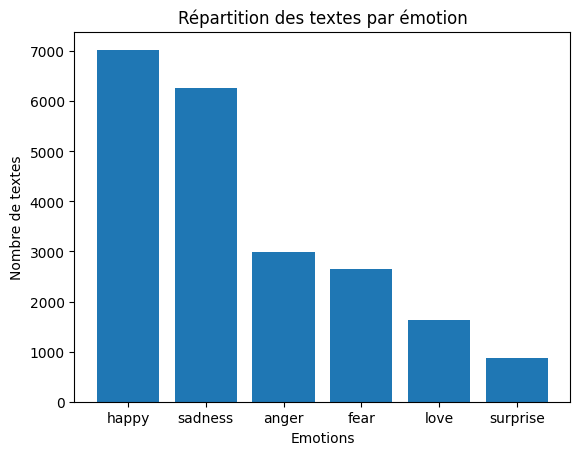

In [5]:
plt.bar(emotion_counts.index,emotion_counts.values)
plt.title('Répartition des textes par émotion')
plt.xlabel('Emotions')
plt.ylabel('Nombre de textes')

### identifiez quels mots sont susceptibles d'être des stopword

In [6]:
nltk.download('stopwords')

stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
all_stopwords = set()
for text in df['Text']:
    words = text.split()
    
    stopwords_in_text = [word for word in words if word.lower() in stopwords_list]
    
    all_stopwords.update(stopwords_in_text)

count_stopwords = len(all_stopwords)
count_stopwords
    

225

### pour chaque sentiment, identifiez les 30 mots les plus courants pour chaque sentiment en dehors des stopwords


In [8]:
from collections import Counter
from nltk.stem import WordNetLemmatizer

common_words_by_sentiment = {}


for sentiment in df['Emotion'].unique():
    # Filtrer les textes par sentiment
    texts = df[df['Emotion'] == sentiment]['Text']
    
    # Concaténer tous les textes en une seule chaîne de caractères
    all_text = ' '.join(texts)
    
    # Diviser la chaîne de caractères en mots
    words = all_text.split()
    
    # Filtrer les mots pour exclure les stopwords
    words = [word for word in words if word.lower() not in stopwords_list]
    
    # Gestion de la ponctuation et des émojis
    words = [word for word in words if word.isalnum()]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    words = [word for word in words if word.lower() not in ['feel', 'feeling', 'im', 'like']]
    
    # Compter la fréquence de chaque mot
    word_counts = Counter(words)
    
    # Sélectionner les 30 mots les plus courants
    top_30_words = word_counts.most_common(30)
    
    # Ajouter les mots les plus courants au dictionnaire par sentiment
    common_words_by_sentiment[sentiment] = top_30_words

for sentiment in df['Emotion'].unique():
    print(f'{sentiment} : {common_words_by_sentiment[sentiment]}')
    

sadness : [('really', 352), ('time', 350), ('know', 350), ('get', 299), ('day', 287), ('would', 273), ('thing', 268), ('little', 267), ('ive', 266), ('make', 266), ('want', 249), ('still', 243), ('life', 243), ('one', 241), ('even', 239), ('people', 231), ('think', 225), ('bit', 221), ('much', 191), ('dont', 190), ('way', 175), ('something', 170), ('back', 168), ('going', 164), ('could', 159), ('go', 150), ('pretty', 146), ('right', 144), ('love', 142), ('need', 142)]
anger : [('time', 174), ('really', 171), ('get', 167), ('know', 151), ('people', 149), ('want', 137), ('little', 136), ('thing', 136), ('even', 124), ('would', 118), ('angry', 116), ('think', 113), ('one', 113), ('way', 111), ('could', 108), ('make', 107), ('bit', 103), ('day', 97), ('offended', 92), ('dont', 91), ('resentful', 87), ('cold', 86), ('still', 85), ('something', 85), ('life', 84), ('irritable', 84), ('cant', 83), ('going', 81), ('bothered', 81), ('need', 80)]
love : [('love', 123), ('really', 112), ('know', 1

### A partir de ces 30 mots, définissez une métrique de proximité entre les sentiments et affichez-la sur une matrice type heatmap

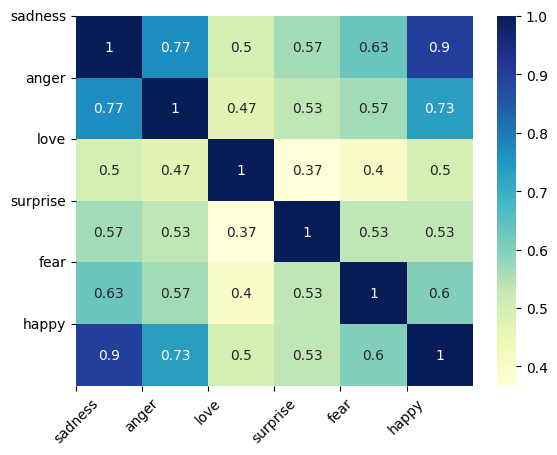

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Créer une liste pour stocker les textes de chaque sentiment
sentiment_texts = []

# Parcourir les 30 mots les plus courants pour chaque sentiment
for sentiment in common_words_by_sentiment:
    top_words = common_words_by_sentiment[sentiment]
    word_list = [word for word, _ in top_words]
    sentiment_texts.append(' '.join(word_list))

# Créer une matrice de termes en utilisant CountVectorizer
vectorizer = CountVectorizer()
term_matrix = vectorizer.fit_transform(sentiment_texts)

# Calculer la similarité cosinus entre les textes
similarity_matrix = cosine_similarity(term_matrix)

# Afficher la matrice de similarité sous forme de heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu')

plt.xticks(ticks=range(len(common_words_by_sentiment)), labels=common_words_by_sentiment.keys(), rotation=45)
plt.yticks(ticks=range(len(common_words_by_sentiment)), labels=common_words_by_sentiment.keys(), rotation=0)

plt.show()



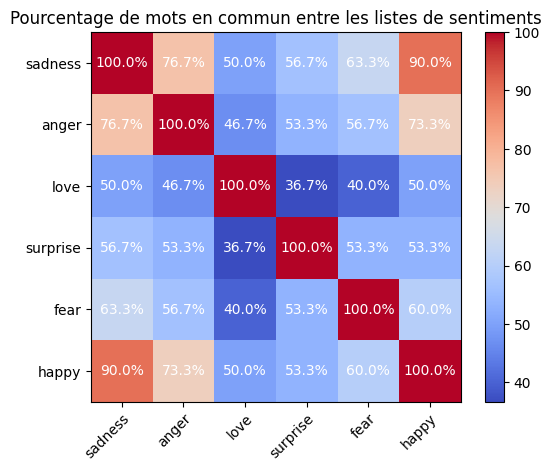

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Liste des sentiments
sentiments = df['Emotion'].unique()

# Matrice pour stocker les pourcentages de mots en commun
common_words_matrix = np.zeros((len(sentiments), len(sentiments)))

# Calcul des pourcentages de mots en commun entre les listes
for i, sent1 in enumerate(sentiments):
    for j, sent2 in enumerate(sentiments):
        words_sent1 = set([word for word, count in common_words_by_sentiment[sent1]])
        words_sent2 = set([word for word, count in common_words_by_sentiment[sent2]])
        common_words = words_sent1 & words_sent2
        percentage = len(common_words) / len(words_sent1) * 100
        common_words_matrix[i, j] = percentage

# Création de la heatmap
fig, ax = plt.subplots()
im = ax.imshow(common_words_matrix, cmap='coolwarm')

# Configuration des axes
ax.set_xticks(np.arange(len(sentiments)))
ax.set_yticks(np.arange(len(sentiments)))
ax.set_xticklabels(sentiments)
ax.set_yticklabels(sentiments)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Affichage des valeurs dans les cellules de la heatmap
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        text = ax.text(j, i, f'{common_words_matrix[i, j]:.1f}%', ha="center", va="center", color="w")

# Ajout d'une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

# Titre de la heatmap
ax.set_title("Pourcentage de mots en commun entre les listes de sentiments")

# Affichage de la heatmap
plt.show()



In [11]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Prétraitement du corpus de texte
all_text_corpus = ' '.join(df['Text'])
tokens = word_tokenize(all_text_corpus)

# Conversion en minuscules et suppression de la ponctuation
tokens = [token.lower() for token in tokens if token not in string.punctuation]

# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Filtrage des stopwords
stopwords_list = stopwords.words('english')
tokens = [token for token in tokens if token not in stopwords_list]

word_freq = FreqDist(tokens)

# Sélectionner les mots à exclure qui apparaissent plus de 100 fois dans le corpus
common_words_to_exclude = [word for word, count in word_freq.items() if count > 100]

from collections import Counter

common_words_by_sentiment = {}

for sentiment in df['Emotion'].unique():
    # Filtrer les textes par sentiment
    texts = df[df['Emotion'] == sentiment]['Text']
    
    # Concaténer tous les textes en une seule chaîne de caractères
    all_text = ' '.join(texts)
    
    # Diviser la chaîne de caractères en mots
    words = all_text.split()
    
    # Filtrer les mots pour exclure les stopwords, la ponctuation et les mots fréquents
    words = [word for word in words if word.lower() not in stopwords_list and word.lower() not in string.punctuation]
    words = [lemmatizer.lemmatize(word.lower()) for word in words]
    words = [word for word in words if word.lower() not in common_words_to_exclude]
    
    # Compter la fréquence de chaque mot
    word_counts = Counter(words)
    
    # Sélectionner les 30 mots les plus courants
    top_30_words = word_counts.most_common(30)
    
    # Ajouter les mots les plus courants au dictionnaire par sentiment
    common_words_by_sentiment[sentiment] = top_30_words

for sentiment in df['Emotion'].unique():
    print(f'{sentiment} : {common_words_by_sentiment[sentiment]}')



sadness : [('ashamed', 87), ('devastated', 87), ('punished', 82), ('shitty', 81), ('embarrassed', 80), ('heartbroken', 80), ('missed', 79), ('discouraged', 78), ('awkward', 78), ('useless', 77), ('dull', 76), ('lethargic', 75), ('unhappy', 74), ('melancholy', 73), ('terrible', 72), ('unwelcome', 71), ('isolated', 71), ('gloomy', 71), ('dumb', 71), ('hopeless', 70), ('burdened', 70), ('aching', 70), ('horrible', 70), ('homesick', 70), ('pathetic', 69), ('ugly', 69), ('groggy', 69), ('vain', 68), ('numb', 68), ('humiliated', 66)]
anger : [('offended', 92), ('resentful', 87), ('irritable', 84), ('bothered', 81), ('greedy', 77), ('mad', 74), ('insulted', 73), ('irritated', 72), ('pissed', 71), ('violent', 70), ('annoyed', 70), ('dissatisfied', 68), ('fucked', 68), ('rude', 68), ('bitchy', 67), ('cranky', 67), ('rushed', 66), ('dangerous', 66), ('selfish', 65), ('bitter', 64), ('disgusted', 64), ('distracted', 64), ('jealous', 61), ('petty', 60), ('wronged', 56), ('impatient', 54), ('rebell

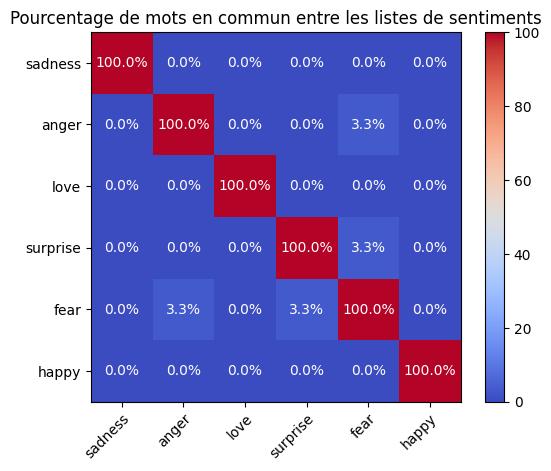

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Liste des sentiments
sentiments = df['Emotion'].unique()

# Matrice pour stocker les pourcentages de mots en commun
common_words_matrix = np.zeros((len(sentiments), len(sentiments)))

# Calcul des pourcentages de mots en commun entre les listes
for i, sent1 in enumerate(sentiments):
    for j, sent2 in enumerate(sentiments):
        words_sent1 = set([word for word, count in common_words_by_sentiment[sent1]])
        words_sent2 = set([word for word, count in common_words_by_sentiment[sent2]])
        common_words = words_sent1 & words_sent2
        percentage = len(common_words) / len(words_sent1) * 100
        common_words_matrix[i, j] = percentage

# Création de la heatmap
fig, ax = plt.subplots()
im = ax.imshow(common_words_matrix, cmap='coolwarm')

# Configuration des axes
ax.set_xticks(np.arange(len(sentiments)))
ax.set_yticks(np.arange(len(sentiments)))
ax.set_xticklabels(sentiments)
ax.set_yticklabels(sentiments)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Affichage des valeurs dans les cellules de la heatmap
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        text = ax.text(j, i, f'{common_words_matrix[i, j]:.1f}%', ha="center", va="center", color="w")

# Ajout d'une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

# Titre de la heatmap
ax.set_title("Pourcentage de mots en commun entre les listes de sentiments")

# Affichage de la heatmap
plt.show()



### Créer deux premiers modèles (Bag of words et TF IDF) en gérant les étapes de tokenisation, de gestion de la ponctuation, des émojis, des stopwords, de lemmatisation ou de streaming.

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Télécharger les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Prétraitement du corpus de texte
all_text_corpus = ' '.join(df['Text'])
tokens = word_tokenize(all_text_corpus)

# Conversion en minuscules et suppression de la ponctuation
tokens = [token.lower() for token in tokens if token not in string.punctuation]

# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Filtrage des stopwords
stopwords_list = stopwords.words('english')
tokens = [token for token in tokens if token not in stopwords_list]

word_freq = FreqDist(tokens)

# Sélectionner les mots à exclure qui apparaissent plus de 100 fois dans le corpus
common_words_to_exclude = [word for word, count in word_freq.items() if count > 100]


# Étape de prétraitement : tokenization, gestion de la ponctuation, des émojis, des stopwords, lemmatisation et streaming

def preprocess_text(text):
    # Tokenization : divise le texte en unités linguistiques
    tokens = word_tokenize(text)
    
    # Gestion de la ponctuation et des émojis
    tokens = [token for token in tokens if token.isalnum()]
    
    # Gestion des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # tokens = [word for word in words if word.lower() not in common_words_to_exclude]
    
    # Streaming pour marquer les négations (ex : "not happy" -> "not_happy")
    tokens = mark_negation(tokens)
    
    # Rejoindre les tokens en une chaîne de texte
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

df['preprocessed_text'] = df['Text'].apply(preprocess_text)

# Création du modèle Bag of Words
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(df['preprocessed_text'])

# Affichage des mots présents dans le modèle Bag of Words
print(bow_vectorizer.get_feature_names_out())

# Création du modèle TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

# Affichage des mots présents dans le modèle TF-IDF
print(tfidf_vectorizer.get_feature_names_out())


[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['10' '11' '13' ... 'zumba_neg' 'zz' 'zzap']
['10' '11' '13' ... 'zumba_neg' 'zz' 'zzap']


###  implémenter un modèle de machine learning de scikit learn

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Division des données en ensembles d'entraînement et de test
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow_features, df['Emotion'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_features, df['Emotion'], test_size=0.2, random_state=42)

# Création et entraînement du modèle Bag of Words
model_bow = LogisticRegression()
model_bow.fit(X_train_bow, y_train)

# Prédictions sur les données de test Bag of Words
predictions_bow = model_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, predictions_bow)
print("Accuracy (Bag of Words):", accuracy_bow)

# Création et entraînement du modèle TF-IDF
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)

# Prédictions sur les données de test TF-IDF
predictions_tfidf = model_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, predictions_tfidf)
print("Accuracy (TF-IDF):", accuracy_tfidf)

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Bag of Words): 0.8774464119291705
Accuracy (TF-IDF): 0.8508853681267474


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
import pickle

# Enregistrement du modèle
with open('model_bow.pkl', 'wb') as fichier:
    pickle.dump(model_bow, fichier)

# Fermeture du fichier
fichier.close()

In [24]:
# Nouveau texte à tester
new_text = "I'm excited"

# Prétraitement du nouveau texte
preprocessed_text = preprocess_text(new_text)

# Vectorisation du texte
new_text_features = bow_vectorizer.transform([preprocessed_text])

# Prédiction sur le nouveau texte
predicted_emotion = model_bow.predict(new_text_features)[0]

# Affichage de la prédiction
print("Predicted Emotion:", predicted_emotion)


Predicted Emotion: happy
